# GLLVM for longitudinal data: a pytorch implementation

We consider the following model


 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable accounts for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order

\begin{equation*}
z_{it}=\phi z_{i,t-1} + \delta_{it}
\end{equation*}%
where  $z_{i1}\sim N(0,\sigma^2_{1})$ and $\delta_{it}\sim N(0,1)$.  Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Changes I propose:

allow x to depend on time.


## Measurement invariance

The  latent variable $z_{it}$ has to be the same (same meaning) across occasions.
Thus the measurement invariance assumption has to be tested on the data, that is 
all the measurement parameters  are invariant across occasions, that is $$\beta_{0jt}=\beta_{0j} \ \textrm{and } \ \lambda_{jt}=
\lambda_{j},$$ for all $t$, $t=1, \ldots, T$ and for all $j$, $j=1,\ldots, p$.
Under this assumption, the model is more parsimonious  and avoids some possible identification problem that might arise with
increasing the number of time points.

To ensure identification of the model, one necessary condition is that the latent variable has a scale and an origin. %When measurement
%invariance of loadings and intercepts is imposed,
Scale for  $z_{it}$  can be provided either by fixing one loading at a nonzero value or by
fixing the factor variance at a nonzero value. In presence of longitudinal data, the same loading is fixed equal to one at each occasion.


## Fast prototyping using Pytorch

We model each observation as a tuple of dimension `(T, p)`, common across individuals. Individuals constitute independent observations, which yields the tensor structure `(n, T, q)`. The time dimension `T` appears in the first dimension since it allows for seamless tensor products of the type `(n, T, q) (q, p)`.

We need

* A model that defines the generative process
* A loss function which, upon taking the derivative, re-creates the estimating equations
* A way to compute the latent variables. For now, we will use a neural network. Later, we can implement the real function.

TODO:
* allow for gaussian and binary data
* Compute the gradient that define the model
* allow for missing values and impute them

In [488]:
import torch
from torch import nn
import numpy as np
import math

n = 200
p = 20
T = 10
k = 5
q = 1

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)

# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        # nuisance parameters
        self.phi = torch.ones(1)
        self.var_u = torch.ones((1,1,p))
        self.var_y = torch.ones((1,1,p))
        self.var_z = torch.ones((1,T,1))

    def encoder_fit(self, x, y, z, u, epochs=100):
        zu = torch.cat([z.squeeze(), u.squeeze()], dim=1).detach()
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            print(f"\nEpoch {epoch}/{epochs}...")
            (zhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(zhat, z) + encoder_loss(uhat, u)
            print(f"loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        
    def sample(self, nb, xb=None, zb=None, ub=None, db=None):
        """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)"""

        if xb is None:
            Warning("xb was set to None for sampling. This is usually unwanted unless k=0.")
            xb = torch.randn((nb, T, k))
        if zb is None:
            zb = torch.randn((nb, T, q)) * torch.sqrt(self.var_z)

        if db is None:
            db = torch.randn((nb, T, q))
        
        if ub is None:
            ub = torch.randn((nb, 1, p)) * torch.sqrt(self.var_u)
        
        zb = self.AR(zb, db)

        eps = torch.randn((nb, T, p)) * torch.sqrt(self.var_y)
        yb = self.decoder(xb, zb, ub) + eps

        return (xb, zb, ub, db, yb)
    
    def AR(self, z, delta):
        assert z.shape == delta.shape  # we draw the same shape for simplicity, even though we don't need delta for t=0.
        for t in range(1, z.shape[1]):
            z[:,t] = z[:, t-1] * self.phi + delta[:,t]
        return z

    def sample_z(self):
        return None

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((q, p)))
        self.wx = nn.Parameter(torch.randn((T, k, p)))
        self.bias = torch.zeros((1, T, p))

    # decoding
    def forward(self, xb, zb, ub):
        xbwx = (xb.unsqueeze(2) @ self.wx).squeeze() # see details of tensorproducts
        zbwz = (zb.unsqueeze(2) @ self.wz).squeeze()
        linpar = self.bias + xbwx + zbwz + ub
        return linpar


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1).detach()
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, zu):
        #output dimension of size (T*Z), p
        z, u = torch.split(zu, [T*q, p], dim=1)
        z = z.reshape((z.shape[0], T, q))
        u = u.unsqueeze(1)
        return (z, u)



In [489]:
gl = GLLVM_longitudinal()
(xb, zb, ub, _, yb) = gl.sample(1000)
gl.encoder_fit(xb, yb, zb, ub, epochs=200)


Epoch 0/200...
loss=26.94855308532715

Epoch 1/200...
loss=28.907224655151367

Epoch 2/200...
loss=24.759052276611328

Epoch 3/200...
loss=22.0222110748291

Epoch 4/200...
loss=20.257596969604492

Epoch 5/200...
loss=18.34127426147461

Epoch 6/200...
loss=16.84316635131836

Epoch 7/200...
loss=15.603940963745117

Epoch 8/200...
loss=14.47238540649414

Epoch 9/200...
loss=13.223315238952637

Epoch 10/200...
loss=11.951873779296875

Epoch 11/200...
loss=10.857407569885254

Epoch 12/200...
loss=9.907062530517578

Epoch 13/200...
loss=9.039861679077148

Epoch 14/200...
loss=8.259664535522461

Epoch 15/200...
loss=7.593719482421875

Epoch 16/200...
loss=7.055300712585449

Epoch 17/200...
loss=6.62669038772583

Epoch 18/200...
loss=6.210526466369629

Epoch 19/200...
loss=5.885904312133789

Epoch 20/200...
loss=5.671491622924805

Epoch 21/200...
loss=5.466911315917969

Epoch 22/200...
loss=5.266020774841309

Epoch 23/200...
loss=5.101892948150635

Epoch 24/200...
loss=5.008647918701172

Epoc

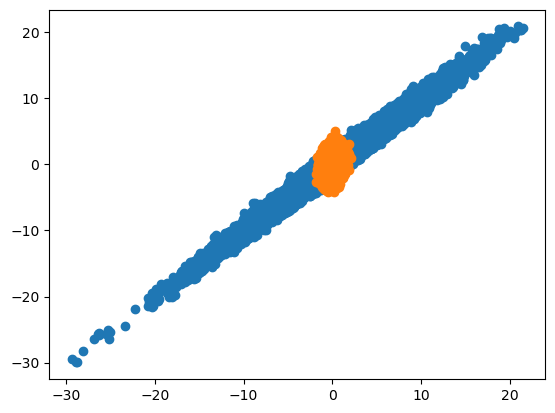

In [490]:
with torch.no_grad():
    (zhat, uhat) = gl.encoder(xb, yb)
import matplotlib.pyplot as plt

plt.scatter(zhat, zb)
plt.scatter(uhat, ub)
plt.show()

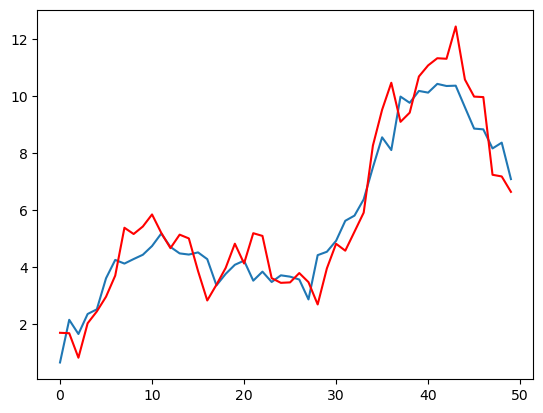

In [493]:
plt.plot(zhat[1,:,0])
plt.plot(zb[1,:, 0], color="red")

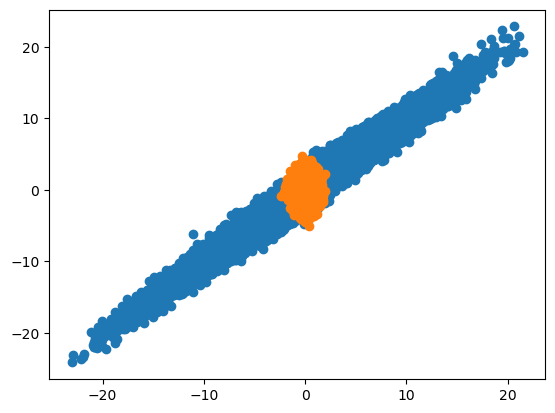

In [492]:
(xb, zb, ub, _, yb) = gl.sample(1000)
with torch.no_grad():
    (zhat, uhat) = gl.encoder(xb, yb)
plt.scatter(zhat, zb)
plt.scatter(uhat, ub)
plt.show()

### Details on tensor products calculations
We now show the details on the tensor products, for instance for computing `xb @ wx`. `xb` is of size `(n, T, q)` and `wx` is of size `(T, q, p)`. We want a result of size `(n, T, p)`. First we add a dimension for `xb`:

`xb.unsqueeze(2)` which yields a dimensions of `(n, T, 1, q)`

which we then multiply by `wz`:

`(n, T, 1, q) @ (1, q, p)` -> `(n, T, 1, p)`

where the first dimension of `wx` has been broadcasted.

Finally, we squeeze to obtain `(n, T, p)`.